In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Instantiate a BigQuery client
client = bigquery.Client(project='logistics-customer-staging')
bq_storage = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\venv_dh\lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [82]:
# Define the global inputs
entity_id = "FP_TH"
test_keyword = "%price sensitivity1%"
analysis_start_date = "2023-03-15" # 2023-06-01 for TW and 2023-03-15 for TH
order_rank_ceiling = pow(10, 6) # Used to limit the number of vendors to plot CVR3 graphs for in the last step. Could either be a small number like 10-20 or a big number to include everything
plot_hue = "test_name" # The hue of the plot at the very last step. Can either ve "vendor_id" or "test_name"
df_agg_metrics_group_by_vars = ["entity_id", "test_name", "variant"] # For vendor level, it would be ["entity_id", "test_name", "vendor_id", "variant"]

# Two parameters used to create a data frame containing bootstrapped elasticity values per price tier per test
num_bootstrap_samples = 500
variant_of_choice = "Variation2"

# Three parameters used to create a data frame containing
max_tier_ela_plots = 4
ntile_bottom = 0.01
ntile_top = 0.99

In [4]:
# Extract order data of these tests
orders_query = """
    WITH test_query AS (
        SELECT DISTINCT test_name
        FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
        WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
    ),
    
    load_scheme_data as (
        SELECT 
            entity_id,
            scheme_id,
            scheme_active_from,
            IFNULL(scheme_active_to, CURRENT_TIMESTAMP()) AS scheme_active_to,
            scheme_component_configs.travel_time_config
        FROM `fulfillment-dwh-production.cl.pricing_configuration_versions`
    ),

    orders AS (
        SELECT 
            -- Identifiers and supplementary fields     
            -- Date and time
            a.created_date AS created_date_utc,
            a.order_placed_at,

            -- Location of order
            ent.segment AS region,
            a.entity_id,
            a.country_code,
            a.city_name,
            a.city_id,
            a.zone_name,
            a.zone_id,

            -- Order/customer identifiers and session data
            a.variant,
            a.experiment_id AS test_id,
            b.test_name,
            a.platform_order_code,
            a.scheme_id,
            a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
            
            -- Vendor data and information on the delivery
            a.vendor_id,
            b.target_group AS target_group_bi,
            a.is_in_treatment,
            a.chain_id,
            a.chain_name,
            a.vertical_type,
            a.delivery_status,
            a.is_own_delivery,
            a.exchange_rate,

            -- Business KPIs (These are the components of profit)
            a.dps_delivery_fee_local,
            a.dps_travel_time_fee_local,
            a.dps_surge_fee_local,
            a.delivery_fee_local,
            IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local) AS delivery_fee_local_incl_disc_and_vouchers,
            CASE WHEN ent.segment != "MENA" THEN a.commission_local ELSE COALESCE(mn.commission_amount_lc, a.commission_local) END AS commission_local,
            a.joker_vendor_fee_local,
            COALESCE(a.service_fee_local, 0) AS service_fee_local,
            a.mov_customer_fee_local AS sof_local,
            a.delivery_costs_local,
            CASE
                WHEN ent.segment IN ("Europe", "Asia") THEN COALESCE( -- Get the delivery fee data of Pandora countries from Pandata tables
                    pd.delivery_fee_local, 
                    -- In 99 pct of cases, we won"t need to use that fallback logic as pd.delivery_fee_local is reliable
                    IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local)
                )
                -- If the order comes from a non-Pandora country, use delivery_fee_local
                WHEN ent.segment NOT IN ("Europe", "Asia") THEN (CASE WHEN a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE THEN 0 ELSE a.delivery_fee_local END)
            END AS actual_df_paid_by_customer,
            a.gfv_local,
            a.gmv_local,
            a.dps_travel_time
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
        LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
        LEFT JOIN `fulfillment-dwh-production.pandata_curated.pd_orders` pd -- Contains info on the orders in Pandora countries
        ON TRUE 
            AND a.entity_id = pd.global_entity_id
            AND a.platform_order_code = pd.code 
            AND a.created_date = pd.created_date_utc -- There is no country_code field in this table
        LEFT JOIN `tlb-data-prod.data_platform.fct_billing` mn ON a.platform_order_code = CAST(mn.order_id AS STRING) AND a.entity_id IN ("TB_OM", "TB_IQ", "TB_AE", "TB_KW", "YS_TR", "TB_QA", "TB_JO", "HF_EG", "HS_SA", "TB_BH")
        INNER JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON a.entity_id = ent.global_entity_id -- Get the region associated with every entity_id
        WHERE TRUE
            AND a.created_date >= DATE("{analysis_start_date_var}")
            AND b.test_name IN (SELECT * FROM test_query) -- Search for relevant tests
            AND a.is_sent -- Successful orders
            AND a.is_own_delivery -- OD orders only
            AND a.variant != "Original" -- Exclude orders from ASAs
            AND a.is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment
    )

    SELECT
        a.*,
        (
            SELECT MIN(tier) + 1 as tier
            FROM UNNEST(travel_time_config) tt
            WITH OFFSET as tier 
            WHERE dps_travel_time <= IFNULL(tt.travel_time_threshold,9999) 
        ) AS tt_tier
    from orders AS a
    LEFT JOIN load_scheme_data sch ON TRUE
        AND a.entity_id = sch.entity_id
        AND a.scheme_id = sch.scheme_id
        AND a.order_placed_at >= scheme_active_from
        AND a.order_placed_at < scheme_active_to
    ;
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the orders query
df_orders = client.query(orders_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [5]:
# Calculate the average DF per variant

# First, filter out orders from ASA
df_orders = df_orders[df_orders["variant"] != "Original"]

# Pick the list of functions for each KPI
list_agg_functions = ["mean", "nunique"]
agg_function_selection = {"delivery_fee_local": "mean", "dps_travel_time_fee_local": "mean", "platform_order_code": "nunique"}

# Perform the aggregation
df_agg_metrics = df_orders.\
    groupby(df_agg_metrics_group_by_vars)[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Create a new data frame showing the values for the control group
df_control = df_orders[df_orders["variant"] == "Control"].\
    groupby(df_agg_metrics_group_by_vars[:-1])[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Join df_agg_metrics with df_control
df_agg_metrics = pd.merge(left=df_agg_metrics, right=df_control, on=df_agg_metrics_group_by_vars[:-1], how="left", suffixes=["", "_control"])

# Change the data types of columns in df_agg_metrics
numerical_cols_df_agg_metrics = ["delivery_fee_local", "dps_travel_time_fee_local", "order_count", "delivery_fee_local_control", "dps_travel_time_fee_local_control", "order_count_control"]
df_agg_metrics[numerical_cols_df_agg_metrics] = df_agg_metrics[numerical_cols_df_agg_metrics].apply(lambda x: pd.to_numeric(x))

# Add new columns showing the elasticity calculations
df_agg_metrics = df_agg_metrics.assign(
    pct_diff_orders=round(df_agg_metrics["order_count"] / df_agg_metrics["order_count_control"] - 1, 4),
    pct_diff_tt_fee=round(df_agg_metrics["dps_travel_time_fee_local"] / df_agg_metrics["dps_travel_time_fee_local_control"] - 1, 4),
    pct_diff_df=round(df_agg_metrics["delivery_fee_local"] / df_agg_metrics["delivery_fee_local_control"] - 1, 4),
    elasticity=round((df_agg_metrics["order_count"] / df_agg_metrics["order_count_control"] - 1) / (df_agg_metrics["dps_travel_time_fee_local"]/df_agg_metrics["dps_travel_time_fee_local_control"] - 1), 4)
)

# Display the final data frame
df_agg_metrics.head()

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity
0,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Control,10.855280,9.874928,32829,10.85528,9.874928,32829,0.0000,0.0000,0.0000,NaN
1,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation1,12.424454,11.789728,32477,10.85528,9.874928,32829,-0.0107,0.1939,0.1446,-0.0553
2,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation2,10.754756,10.014298,33012,10.85528,9.874928,32829,0.0056,0.0141,-0.0093,0.3950
3,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation3,6.549216,5.524936,36614,10.85528,9.874928,32829,0.1153,-0.4405,-0.3967,-0.2617
4,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation4,8.117863,7.096846,33734,10.85528,9.874928,32829,0.0276,-0.2813,-0.2522,-0.0980


In [6]:
# Extract sessions data of these tests
sessions_query = """
  WITH test_query AS (
    SELECT DISTINCT test_name
    FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
    WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
  )

  SELECT
    entity_id,
    created_date,
    created_at,
    test_name,
    ga_session_id,
    variant,
    test_zone_id AS zone_id,
    perseus_client_id,
    vendor_code AS vendor_id,
    target_group,
    treatment,
    shop_list_no,
    shop_menu_no,
    checkout_no,
    transaction_no,
  FROM `fulfillment-dwh-production.cl.dps_cvr_ab_tests_treatment`
  WHERE TRUE
    AND created_date >= "{analysis_start_date_var}"
    AND test_name IN (SELECT * FROM test_query) -- Search for relevant tests
    AND vertical_parent_in_test = TRUE -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment
    AND variant != "Original" -- Filter out sessions with variant = "Original"
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the sessions query
df_sessions = client.query(sessions_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [7]:
def count_unique_non_null(x):
    return x.nunique(dropna=True)

# Perform the aggregation
df_agg_cvr = df_sessions.\
    groupby(df_agg_metrics_group_by_vars)[["ga_session_id", "shop_list_no", "shop_menu_no", "checkout_no", "transaction_no"]].\
    agg(count_unique_non_null).\
    reset_index()

# Add new columns calculating CVR
df_agg_cvr["cvr"] = round(df_agg_cvr["transaction_no"] / df_agg_cvr["ga_session_id"], 4)
df_agg_cvr["cvr3"] = round(df_agg_cvr["transaction_no"] / df_agg_cvr["shop_menu_no"], 4)

# Create a new data frame showing the values for the control group
df_agg_cvr = pd.merge(
    left=df_agg_cvr,
    right=df_agg_cvr[df_agg_cvr["variant"] == "Control"][df_agg_metrics_group_by_vars[:-1] + ["cvr", "cvr3"]],
    on=df_agg_metrics_group_by_vars[:-1],
    how="left",
    suffixes=["", "_control"]
)

# Calculate the CVR % difference between variation and control
df_agg_cvr = df_agg_cvr.assign(
    pct_diff_cvr=round(df_agg_cvr["cvr"] / df_agg_cvr["cvr_control"] - 1, 4),
    pct_diff_cvr3=round(df_agg_cvr["cvr3"] / df_agg_cvr["cvr3_control"] - 1, 4),
)
df_agg_cvr.head()

,entity_id,test_name,variant,ga_session_id,shop_list_no,shop_menu_no,checkout_no,transaction_no,cvr,cvr3,cvr_control,cvr3_control,pct_diff_cvr,pct_diff_cvr3
0,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Control,59683,31654,55839,30306,28454,0.4768,0.5096,0.4768,0.5096,0.0000,0.0000
1,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation1,60503,31865,56451,30050,27999,0.4628,0.4960,0.4768,0.5096,-0.0294,-0.0267
2,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation2,60595,32519,56544,30252,28452,0.4695,0.5032,0.4768,0.5096,-0.0153,-0.0126
3,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation3,65442,35480,61086,33484,31507,0.4814,0.5158,0.4768,0.5096,0.0096,0.0122
4,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation4,60726,33308,56772,31166,29296,0.4824,0.5160,0.4768,0.5096,0.0117,0.0126


In [8]:
# Join df_agg_cvr to df_agg_metrics
df_agg_metrics = pd.merge(
    left=df_agg_metrics,
    right=df_agg_cvr[df_agg_metrics_group_by_vars + ["cvr", "pct_diff_cvr", "cvr3", "pct_diff_cvr3"]],
    on=df_agg_metrics_group_by_vars,
    how="left"
)
df_agg_metrics.head()

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity,cvr,pct_diff_cvr,cvr3,pct_diff_cvr3
0,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Control,10.855280,9.874928,32829,10.85528,9.874928,32829,0.0000,0.0000,0.0000,NaN,0.4768,0.0000,0.5096,0.0000
1,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation1,12.424454,11.789728,32477,10.85528,9.874928,32829,-0.0107,0.1939,0.1446,-0.0553,0.4628,-0.0294,0.4960,-0.0267
2,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation2,10.754756,10.014298,33012,10.85528,9.874928,32829,0.0056,0.0141,-0.0093,0.3950,0.4695,-0.0153,0.5032,-0.0126
3,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation3,6.549216,5.524936,36614,10.85528,9.874928,32829,0.1153,-0.4405,-0.3967,-0.2617,0.4814,0.0096,0.5158,0.0122
4,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation4,8.117863,7.096846,33734,10.85528,9.874928,32829,0.0276,-0.2813,-0.2522,-0.0980,0.4824,0.0117,0.5160,0.0126


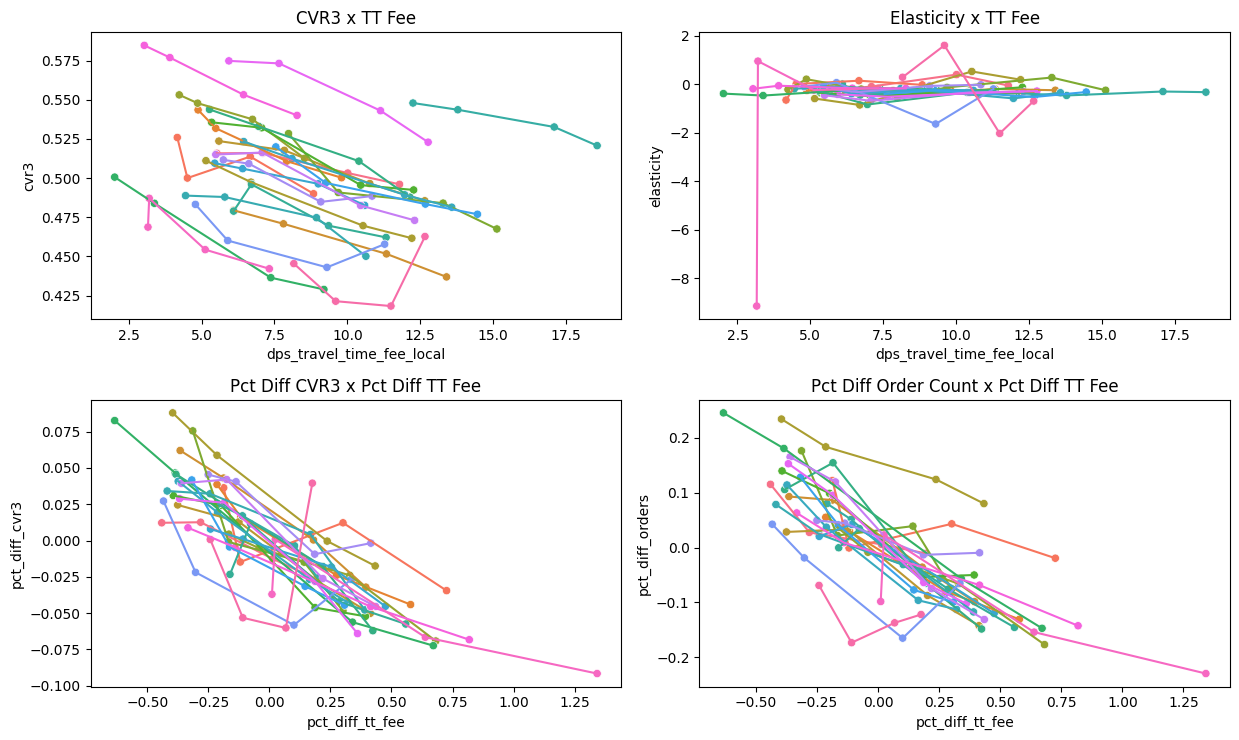

In [9]:
# Create the data frame for plotting
# Include this condition if you wish to exclude the outlier tests --> ~(df_agg_metrics["test_name"].isin(["20230601_TW_R_Elasticity_Penghu", "20230601_TW_R_Elasticity_Kinmen"]))
df_plot = df_agg_metrics[(df_agg_metrics["variant"] != "Control")]\
    [df_agg_metrics_group_by_vars + ["pct_diff_tt_fee", "pct_diff_orders", "pct_diff_cvr", "pct_diff_cvr3", "elasticity", "dps_travel_time_fee_local", "order_count", "cvr", "cvr3"]]

# Create a total_order_rank column in case you want to plot the CVR3 graphs for a subset of vendors
df_plot["total_orders"] = df_plot.groupby(df_agg_metrics_group_by_vars[:-1])["order_count"].transform('sum')
df_plot = df_plot.sort_values(["entity_id", "test_name", "total_orders"], ascending=[True, True, False])
df_plot['rank_total_orders'] = df_plot['total_orders'].rank(ascending=False, method='dense')
df_plot = df_plot[df_plot["rank_total_orders"] <= order_rank_ceiling]

# Create some EDA plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12.5, 7.5))

# 1st chart: TT fee x CVR
sns.scatterplot(data=df_plot, x="dps_travel_time_fee_local", y="cvr3", hue=plot_hue, ax=axes[0,0])
sns.lineplot(data=df_plot, x="dps_travel_time_fee_local", y="cvr3", hue=plot_hue, ax=axes[0,0])
axes[0,0].set_title("CVR3 x TT Fee")

# 2nd chart: TT fee x elasticity
sns.scatterplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue=plot_hue, ax=axes[0,1])
sns.lineplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue=plot_hue, ax=axes[0,1])
axes[0,1].set_title("Elasticity x TT Fee")

# 3rd chart: Pct Diff TT fee x Pct Diff CVR
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr3", hue=plot_hue, ax=axes[1,0])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr3", hue=plot_hue, ax=axes[1,0])
axes[1,0].set_title("Pct Diff CVR3 x Pct Diff TT Fee")

# 4th chart: pct_diff_tt_fee x pct_diff_orders
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue=plot_hue, ax=axes[1,1])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue=plot_hue, ax=axes[1,1])
axes[1,1].set_title("Pct Diff Order Count x Pct Diff TT Fee")

# Remove the legends
axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()

# Right layout
plt.tight_layout()

In [ ]:
# Create a data frame containing bootstrapped elasticity values for variant 2 in each test
df_sim_results = []
sim_counter = 1
for i in df_orders["test_name"].unique().tolist()[0:10]:
    # Filter the original data frame for a specific test and orders belonging to variant 2 ONLY
    df_bootstrap = df_orders[(df_orders["test_name"] == i) & (df_orders["variant"].isin(["Control", variant_of_choice]))]
    
    # Find how many price tiers are in that test
    price_tiers = df_bootstrap["tt_tier"].unique().tolist()
    price_tiers.sort()

    for j in price_tiers:
        # Filter the data based on the price tier
        df_sub_test = df_bootstrap[(df_bootstrap["tt_tier"] == j)]
        
        # Elasticity calculated by pct difference in no. of transactions / pct difference in average DF
        for k in range(1, num_bootstrap_samples + 1):
            print(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {i}, price tier: {j}, sample_num: {k}")
            df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
            df_var_sample = df_sub_test[df_sub_test["variant"] == variant_of_choice].sample(frac=1, replace=True)

            num_orders_ctl = df_ctl_sample["platform_order_code"].count()
            num_orders_var = df_var_sample["platform_order_code"].count()

            try:
                avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
                avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var
                
                avg_tt_fee_ctl = df_ctl_sample["dps_travel_time_fee_local"].sum() / num_orders_ctl
                avg_tt_fee_var = df_var_sample["dps_travel_time_fee_local"].sum() / num_orders_var

                pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
                pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)
                pct_diff_tt_fee = float((avg_tt_fee_var - avg_tt_fee_ctl) / avg_tt_fee_ctl)

                elasticity = pct_diff_orders / pct_diff_avg_df

                output_dict = {
                    "test_name": i,
                    "price_tier": j,
                    "sample_num": k,
                    "avg_df_ctl": avg_df_ctl,
                    "avg_df_var": avg_df_var,
                    "avg_tt_fee_ctl": avg_tt_fee_ctl,
                    "avg_tt_fee_var": avg_tt_fee_var,
                    "orders_tier_ctl": num_orders_ctl,
                    "orders_tier_var": num_orders_var,
                    "total_orders_tier": num_orders_ctl + num_orders_var,
                    "elasticity": elasticity,
                    "pct_diff_orders": pct_diff_orders,
                    "pct_diff_avg_df": pct_diff_avg_df,
                    "pct_diff_tt_fee": pct_diff_tt_fee,
                }

                df_sim_results.append(output_dict)

                # Increment the sim counter
                sim_counter += 1
            except Exception as err:
                print(err)
                break

df_sim_results = pd.DataFrame(df_sim_results)

Text(0.5, 1.0, 'Number of Orders Per Tier Per Test')

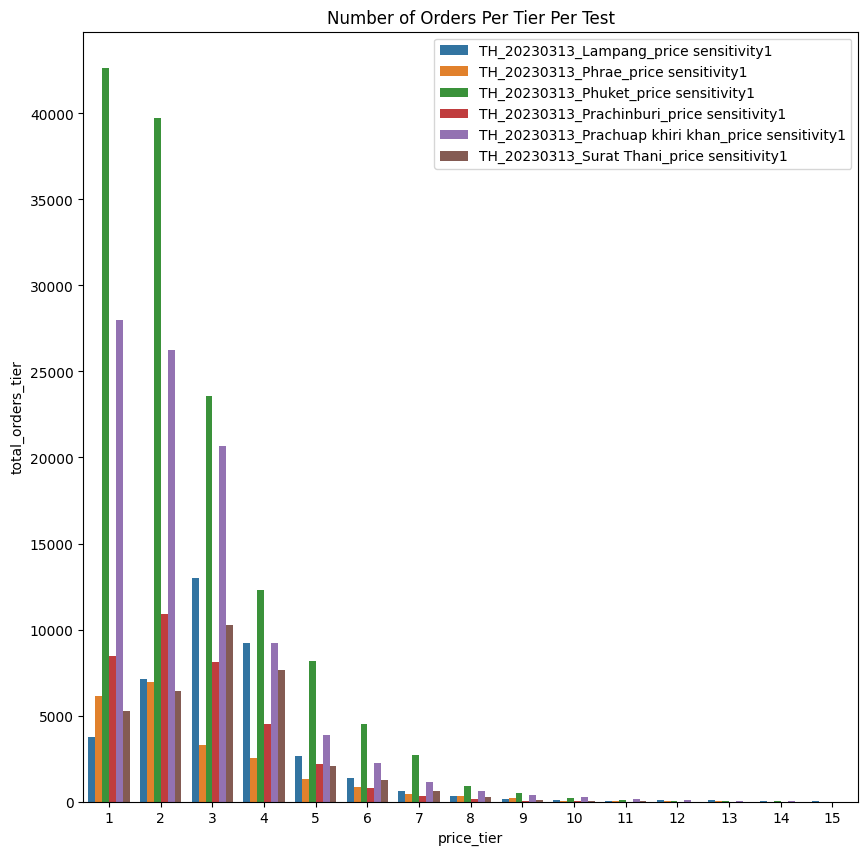

In [89]:
# Compute the average number of orders per tier per test
df_orders_test_tier = df_sim_results.groupby(["test_name", "price_tier"], as_index=False)[["orders_tier_ctl", "orders_tier_var", "total_orders_tier"]].mean().round(0)
df_orders_test_tier.head()

plt.figure(figsize=(10, 10))

# Plot the number of orders per tier test
sns.barplot(
    data=df_orders_test_tier,
    x="price_tier",
    y="total_orders_tier",
    hue="test_name"
)
plt.legend(loc="upper right")
plt.title("Number of Orders Per Tier Per Test")

In [90]:
# Calculate the total orders per test and get the six tests with the largest number of orders
df_orders_test_for_plot = df_orders_test_tier.groupby("test_name", as_index=False)["total_orders_tier"].sum().sort_values("total_orders_tier", ascending=False).reset_index(drop=True)
df_orders_test_for_plot.head()

# Tests to consider for the tier elasticity plots
tests_tier_ela_plots = df_orders_test_for_plot["test_name"].loc[0:5].tolist()
tests_tier_ela_plots

['TH_20230313_Phuket_price sensitivity1',
 'TH_20230313_Prachuap khiri khan_price sensitivity1',
 'TH_20230313_Lampang_price sensitivity1',
 'TH_20230313_Prachinburi_price sensitivity1',
 'TH_20230313_Surat Thani_price sensitivity1',
 'TH_20230313_Phrae_price sensitivity1']

C:\Users\o.elmaria\AppData\Local\Temp\ipykernel_22492\1113428522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ela_plot[f"ntile_{ntile_bottom}"] = df_ela_plot.groupby(["test_name"])["elasticity"].transform(lambda x: x.quantile(ntile_bottom))
C:\Users\o.elmaria\AppData\Local\Temp\ipykernel_22492\1113428522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ela_plot[f"ntile_{ntile_top}"] = df_ela_plot.groupby(["test_name"])["elasticity"].transform(lambda x: x.quantile(ntile_top))


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'TH_20230313_Phuket_price sensitivity1'),
  Text(1, 0, 'TH_20230313_Prachuap khiri khan_price sensitivity1'),
  Text(2, 0, 'TH_20230313_Lampang_price sensitivity1'),
  Text(3, 0, 'TH_20230313_Prachinburi_price sensitivity1'),
  Text(4, 0, 'TH_20230313_Surat Thani_price sensitivity1'),
  Text(5, 0, 'TH_20230313_Phrae_price sensitivity1')])

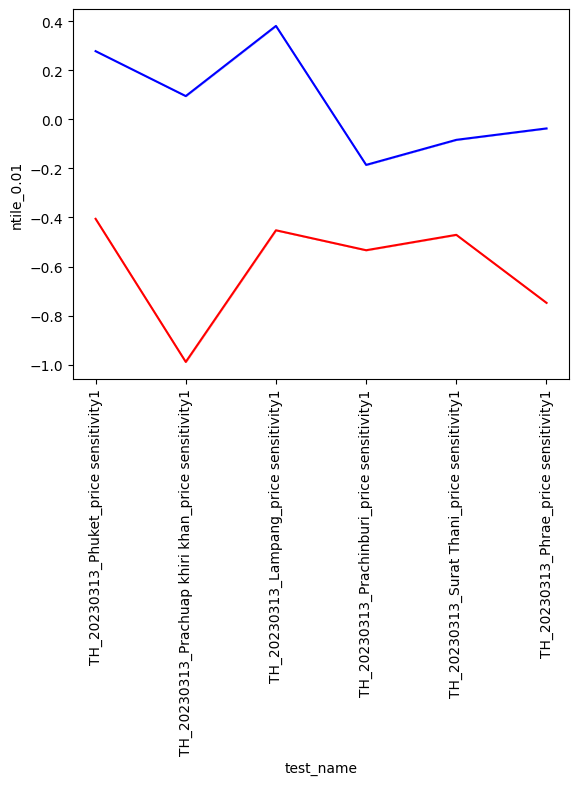

In [91]:
# Filter df_sim_results for orders belonging to tiers 1-6 ONLY
df_ela_plot = df_sim_results[(df_sim_results["price_tier"] <= max_tier_ela_plots) & (df_sim_results["test_name"].isin(tests_tier_ela_plots))]

# Add two new columns to the data frame to calculate the 0.02st and 98th percentiles
df_ela_plot[f"ntile_{ntile_bottom}"] = df_ela_plot.groupby(["test_name"])["elasticity"].transform(lambda x: x.quantile(ntile_bottom))
df_ela_plot[f"ntile_{ntile_top}"] = df_ela_plot.groupby(["test_name"])["elasticity"].transform(lambda x: x.quantile(ntile_top))

# Filter the data set to only keep the elasticities between ntile_bottom and ntile_top
df_ela_plot = df_ela_plot[(df_ela_plot["elasticity"] >= df_ela_plot[f"ntile_{ntile_bottom}"]) & (df_ela_plot["elasticity"] <= df_ela_plot[f"ntile_{ntile_top}"])]

# Plot the values of the percentiles on a line plot
sns.lineplot(
    data=df_ela_plot,
    x="test_name",
    y=f"ntile_{ntile_bottom}",
    color="red"
)
sns.lineplot(
    data=df_ela_plot,
    x="test_name",
    y=f"ntile_{ntile_top}",
    color="blue"
)
plt.xticks(rotation=90)

g:\My Drive\APAC\venv_dh\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Elasticity Per Travel Time Tier for Several Tests')

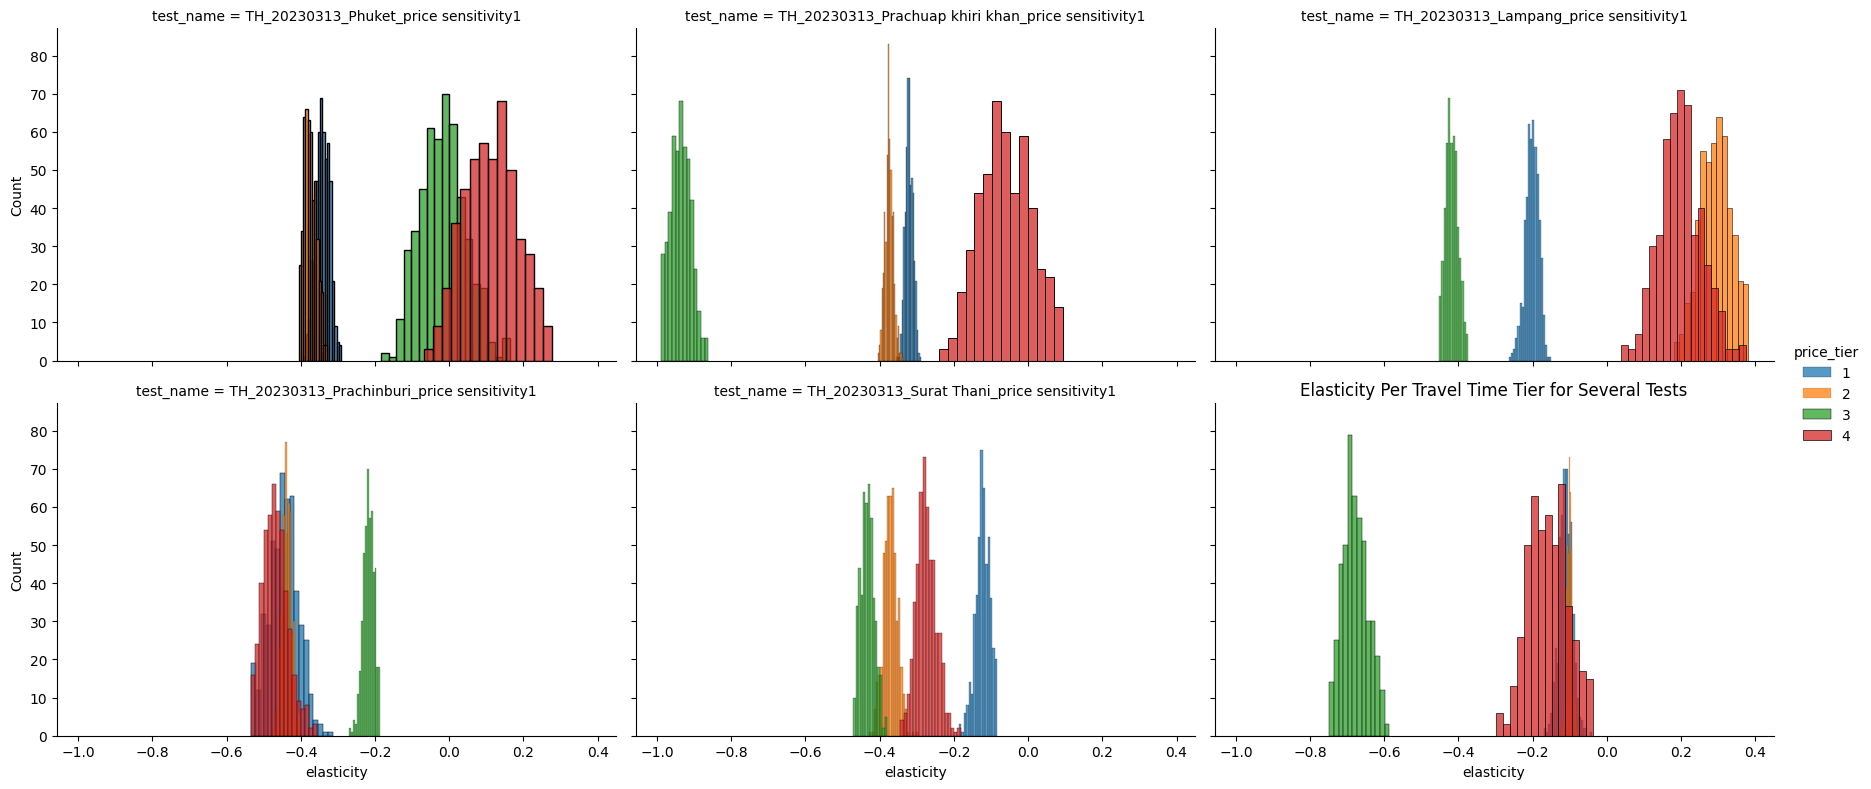

In [92]:
# Create a FacetGrid to plot the elasticity distributions per tier per test
grid = sns.FacetGrid(
    data=df_ela_plot,
    col="test_name",
    hue="price_tier",
    height=4,
    aspect=1.5,
    col_wrap=3,
    palette="tab10"
)
grid.map_dataframe(sns.histplot, x="elasticity")
grid.add_legend()
plt.title("Elasticity Per Travel Time Tier for Several Tests")

In [99]:
# Display the TT fee per price tier-test combination
df_ela_plot.groupby(["test_name", "price_tier"], as_index=False)[["avg_tt_fee_ctl", "avg_tt_fee_var", "pct_diff_tt_fee"]].mean()

,test_name,price_tier,avg_tt_fee_ctl,avg_tt_fee_var,pct_diff_tt_fee
0,TH_20230313_Lampang_price sensitivity1,1,3.05148,6.090837,0.998395
1,TH_20230313_Lampang_price sensitivity1,2,9.344772,12.166494,0.302041
2,TH_20230313_Lampang_price sensitivity1,3,14.842899,17.796026,0.198985
3,TH_20230313_Lampang_price sensitivity1,4,15.951389,19.09275,0.196974
4,TH_20230313_Phrae_price sensitivity1,1,4.837529,7.121736,0.472652
5,TH_20230313_Phrae_price sensitivity1,2,2.712255,5.791823,1.136317
6,TH_20230313_Phrae_price sensitivity1,3,16.29621,19.422875,0.191970
7,TH_20230313_Phrae_price sensitivity1,4,16.106434,19.248827,0.195227
8,TH_20230313_Phuket_price sensitivity1,1,13.253069,15.147391,0.142945
9,TH_20230313_Phuket_price sensitivity1,2,16.167636,18.625305,0.152020
